# K-median 問題

k-median問題では、データ点を$k$個のクラスタに分割するとき、そのクラスタに属する点とクラスタ中心となるデータ点との距離の合計を最小にすることを目指します。
これはk-meansクラスタリングの派生系とも呼べるものです。
k-meansクラスタリングでは、各クラスタの平均値を計算することでクラスタの重心を決定していましたが、k-medianでは中央値を計算します。
この問題はNP困難として知られています。今回はk-median問題の数理モデルをJijModelingで実装し、JijSolverで解いてみましょう。

## 数理モデル

では数理モデルを考えていきましょう。

### 決定変数

$i$番目のデータ点が$j$番目の中央値となるデータ点に属するとき$x_{i, j}=1$、そうでないとき$x_{i, j}=0$となるバイナリ変数を用います。
また$j$番目のデータ点が中央値となるとき$y_j=1$、そうでないとき$y_j = 0$となるバイナリ変数を用います。数式で表すと

$$
x_{i,j} = \begin{cases}
1,~\text{Node $i$ is covered by median $j$}\\
0,~\text{Otherwise}
\end{cases}
$$

$$
y_j = \begin{cases}
1,~\text{Node $j$ is a median.}\\
0,~\text{Otherwise}
\end{cases}
$$

のようになります。

### 数理モデルの構築

$i$番目のデータ点と$j$番目の中央値となる点の距離$d_{i, j}$の合計を最小化することを目的関数にします。
このとき、

1. データ点はどこか1つの中央値となるデータ点に属さなければならない
2. 中央値となるデータ点を$k$個決定しなければならない
3. データ点は中央値となる点に属さなければならない

という3つの制約を満たす必要があります。
これらを数式で表現すると、以下のようになります。

$$
\begin{aligned}
\min_x &\sum_{i}\sum_j d_{i,j}x_{i,j} \\
\mathrm{s.t.}~&\sum_{j} x_{i,j} = 1,~\forall i\\
&\sum_j y_j = k\\
&x_{i,j} \leq y_j, ~\forall i, j\\
&x_{i,j} \in \{0, 1\} ~\forall i, j\\
&y_j \in \{0, 1\}~\forall j
\end{aligned} \tag{1}
$$

## JijModelingによる定式化

上述の数理モデルを実装していきましょう。
まずは必要となる変数を定義します。

In [1]:
import jijmodeling as jm

d = jm.Placeholder("d", ndim=2)
N = d.len_at(0, latex="N")
J = jm.Placeholder("J", ndim=1)
k = jm.Placeholder("k")
i = jm.Element("i", belong_to=(0, N))
j = jm.Element("j", belong_to=J)
x = jm.BinaryVar("x", shape=(N, J.shape[0]))
y = jm.BinaryVar("y", shape=(J.shape[0],))

`d`は各データ点と中央値点との距離を表す2次元配列です。
`d`の要素数からデータ点の数`N`の情報を抽出しています。
`J`は中央値となる点のインデックスの候補を表した1次元配列です。
`k`が最終的に決定される中央値点の数を表します。
`i`, `j`はそれぞれ、バイナリ変数で用いる添字を表します。
最後に、この最適化問題を解くために必要なバイナリ変数`x`, `y`を定義しています。

続いて、式(1)を実装しましょう。

In [2]:
problem = jm.Problem("k-median")
problem += jm.sum([i, j], d[i, j]*x[i, j])
problem += jm.Constraint("onehot", x[i, :].sum() == 1, forall=i)
problem += jm.Constraint("k-median", y[:].sum() == k)
problem += jm.Constraint("cover", x[i, j] <= y[j], forall=[i, j])

`jm.Constraint("onehot", x[i, :] == 1, forall=i)`で、全ての$i$に対して$\sum_j x_{i, j} = 1$が成り立つことを制約として挿入しています。
`jm.Constraint("k-median", y[:] == k)`は$\sum_j y_j = k$を表します。
`jm.Constraint("cover", x[i, j] <= y[j], forall=[i, j])`は、全ての$i, j$に対して$x_{i, j} \leq y_j$でなければならないことを要請しています。

実装された数理モデルを、Jupyter上で表示してみましょう。

In [3]:
problem

## インスタンスの準備

必要となるデータ点を準備しましょう。

In [6]:
import matplotlib.pyplot as plt
import numpy as np

num_nodes = 30
X, Y = np.random.uniform(0, 1, (2, num_nodes))

plt.plot(X, Y, "o")

各データ点どうしの距離を計算しましょう。

In [7]:
XX, XX_T = np.meshgrid(X, X)
YY, YY_T = np.meshgrid(Y, Y)
inst_d = np.sqrt((XX - XX_T)**2 + (YY - YY_T)**2)
inst_J = np.arange(0, num_nodes)
inst_k = 4

instance_data = {"d": inst_d, "J": inst_J, "k": inst_k}

## Jijsolverで解く

`jijsolver`を用いて、k-median問題を解きましょう。

In [8]:
import jijsolver

interpreter = jm.Interpreter(instance_data)
instance = interpreter.eval_problem(problem)
solution = jijsolver.solve(instance, time_limit_sec=1.0)

## 解の可視化

求まった解を可視化してみましょう。

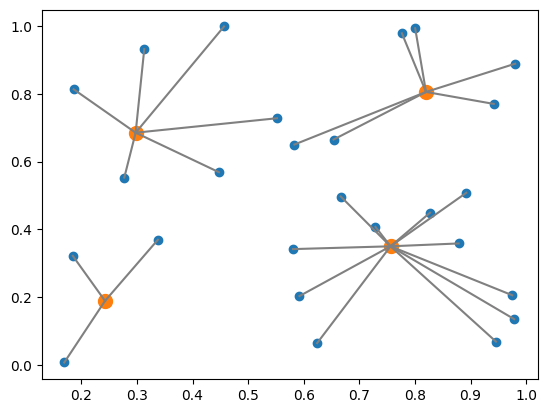

In [9]:
df = solution.decision_variables
y_indices = np.ravel(df[(df["name"] == "y") & (df["value"] == 1.0)]["subscripts"].to_list())
x_indices = df[(df["name"] == "x") & (df["value"] == 1.0)]["subscripts"].to_list()

median_X, median_Y = X[y_indices], Y[y_indices]
d_from_m = np.sqrt((X[:, None]-X[y_indices])**2 + (Y[:, None]-Y[y_indices])**2)
cover_median = y_indices[np.argmin(d_from_m, axis=1)]
plt.plot(X, Y, "o")
plt.plot(X[y_indices], Y[y_indices], "o", markersize=10)
plt.plot(np.column_stack([X, X[cover_median]]).T, np.column_stack([Y, Y[cover_median]]).T, c="gray")
plt.show()

データ点がどのようにクラスターに属しているかを表す図が表示されています。
オレンジ点は中央値となる点、青点はその他のデータ点を表しています。
また灰色線は、中央値となる点とそのクラスターに属するデータ点を結んでいます。